In [223]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from skimage.measure import label

# define a grid to interpolation profiles to

zhgts = 250. + 250.*np.arange(60)

_nthreads = 2
percent = (75,90,95)

#---------------------------------------------------------------------
def interp3dz_np(data, z3d, z1d, nthreads = _nthreads):
    
    dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)

    if nthreads < 0:  # turning this off for now.
        def worker(j):
            print("running %d %s" % (i, data.shape))
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        pool = mp.Pool(nthreads)
        for i in np.arange(data.shape[2]):
            pool.apply_async(worker, args = (i, ))
        pool.close()
        pool.join()
        
        return dinterp
    
    else:        
        for j in np.arange(data.shape[1]):
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        return dinterp
    
#---------------------------------------------------------------------
def write_3D_profile(data, model='WRF', time=0, i0=0, j0=0):
    
    print('#-----------------------------#')
    print('          %s                  ' % model)
    print('#-----------------------------#')
    
    for k in np.arange(data['thetap'].shape[1]):
        
        print(' {:02} {:12.4f} {:12.4f} {:12.4f} {:12.4f}'.format(k,data['z3d'][time,k,i0,j0],   \
                                                                     data['pres'][time,k,i0,j0],  \
                                                                     data['theta'][time,k,i0,j0], \
                                                                     data['den'][time,k,i0,j0]) )


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
def read_model_fields(run_dir, model_type='wrf', printout=False):
    
    if model_type == 'wrf':
        
        def open_mfdataset_list(data_dir, pattern, skip=0):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            
            if skip > 0:
                filelist = filelist[0:-1:skip]
                
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['Time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,  "wrfout*")

        w      = ds.W.values
        w      = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])
        ppres  = ds.P.values
        pbase  = ds.PB.values
        pres   = ppres + ds.PB.values
        tbase  = ds.T_BASE.values
        tbase  = np.broadcast_to(tbase[:, :, np.newaxis, np.newaxis], w.shape)
        theta  = ds.T.values
        thetap = theta - tbase
        z      = ds.PHB.values/9.806
        pi     = (pres/100000.)**0.286
        den    =  pres / (287.04*(theta+300.)*pi)
        z3d    = ds.PHB.values/9.806
        z3d    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])
        
        ds.close()

        out = {'w': w, 'ppres': ppres, 'thetap': thetap, 'den': den, 'pi': pi, 'z3d': z3d, 'pres': pres, 'theta': theta}
        
        if printout:
            write_3D_profile(out, model='WRF')
            
        return out
    
    if model_type == 'fv3':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,   "*.nc")

        w      = ds.W.values
        tbase  = ds.T.values[0,:,-1,-1] + 300.
        tbase  = np.broadcast_to(tbase[np.newaxis, :, np.newaxis, np.newaxis], w.shape)
        theta  = ds.T.values + 300.
        thetap = theta - tbase
        ppres  = ds.P.values
        pbase  = ds.PB.values
        pres   = ppres + pbase
        z3d    = ds.PHB.values/9.806
        pi     = (pres/100000.)**0.286
        den    =  pres / (287.04*(theta)*pi)
        
        ds.close()

        out = {'w': w, 'ppres': ppres, 'thetap': thetap, 'den': den, 'pi': pi, 'z3d': z3d, 'pres': pres, 'theta': theta}
        
        if printout:
            write_3D_profile(out, model='FV3')
            
        return out

    
    if model_type == 'cm1':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, parallel=True)
    
        ds = open_mfdataset_list(run_dir,  "cm1out_0000*.nc")

        w      = ds.winterp.values
        tbase  = ds.th0.values
        thetap = ds.thpert.values
        theta  = thetap + tbase
        pres   = ds.prs.values
        ppres  = ds.prspert.values
        pi     = (pres/100000.)**0.286
        den    = pres / (287.04*(thetap+tbase)*pi)
        z      = ds.zh.values * 1000. # heights are in km
        z3d    = np.broadcast_to(z[np.newaxis, :, np.newaxis, np.newaxis], w.shape)
        
        out = {'w': w, 'ppres': ppres, 'thetap': thetap, 'den': den, 'pi': pi, 'z3d': z3d, 'pres': pres, 'theta': theta}
        
        if printout:
            write_3D_profile(out, model='CM1')
            
        return out
    

In [221]:
def generate_ideal_profiles(fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None):
        
    w      = fields['w']
    thetap = fields['thetap']
    ppres  = fields['ppres']
    den    = fields['den']
    z3d    = fields['z3d']
    
    profiles = compute_profiles(w, thetap, ppres, den, z3d, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix, percentiles=percentiles)
    
    return profiles

#-------------------------------------------------------------------------------
def compute_profiles(W, T, P, D, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5, percentiles=None):
        
    wlist   = [] 
    plist   = []
    tlist   = []
    dlist   = []
    
    jloc  = [126,129]
    iloc  = [126,129]
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.            
        
        # check to see if there are objects
        
        wraw    = W[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get w_raw profiles
        praw    = P[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get p_raw profiles
        zraw    = Z[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get z_raw profiles
        traw    = T[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get t_raw profiles
        draw    = D[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get den_raw profiles
        
        if(wraw.ndim > 2):
            wraw = np.reshape(wraw, (wraw.shape[0],wraw.shape[1]*wraw.shape[2]))      
            zraw = np.reshape(zraw, (zraw.shape[0],zraw.shape[1]*zraw.shape[2]))
            praw = np.reshape(praw, (praw.shape[0],praw.shape[1]*praw.shape[2]))
            traw = np.reshape(traw, (traw.shape[0],traw.shape[1]*traw.shape[2]))
            draw = np.reshape(draw, (draw.shape[0],draw.shape[1]*draw.shape[2]))

        wprofile = interp3dz_np(wraw, zraw, zhgts, nthreads = _nthreads)
        pprofile = interp3dz_np(praw, zraw, zhgts, nthreads = _nthreads)
        tprofile = interp3dz_np(traw, zraw, zhgts, nthreads = _nthreads)
        dprofile = interp3dz_np(draw, zraw, zhgts, nthreads = _nthreads)

        wlist.append([wprofile.mean(axis=1)],)
        plist.append([pprofile.mean(axis=1)],)
        tlist.append([tprofile.mean(axis=1)],)
        dlist.append([dprofile.mean(axis=1)],)
                            
    if( len(wlist) < 1 ):
        
        print("\n ---> Compute_Profiles found no objects...returning zeros ...\n")
        return [np.zeros((zhgts.shape[0],1)), np.zeros((zhgts.shape[0],1)), np.zeros((zhgts.shape[0],1))]
    
    else:
        
        wprofiles = np.squeeze(np.asarray(wlist), axis=1).transpose()
        pprofiles = np.squeeze(np.asarray(plist), axis=1).transpose()
        tprofiles = np.squeeze(np.asarray(tlist), axis=1).transpose()
        dprofiles = np.squeeze(np.asarray(dlist), axis=1).transpose()

        return {'w': wprofiles, 'p': pprofiles, 't': tprofiles, 'd':dprofiles}

In [227]:
# plot some time series...

# WRF ######

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = './'

wrf_fields = read_model_fields(str(os.path.join(in_dir, "WRF_bubble_5K_10s")), model_type='wrf', printout=True)
wrf_profiles = generate_ideal_profiles(wrf_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)




#-----------------------------#
          WRF                  
#-----------------------------#
 00      10.6417   99875.4609       0.0000       1.1602
 01      39.8884   99543.1641       0.0000       1.1575
 02      81.8503   99067.7109       0.0000       1.1535
 03     134.8832   98469.2031       0.0000       1.1486
 04     200.5168   97732.0703       0.0000       1.1424
 05     278.6691   96859.4531       0.0000       1.1351
 06     369.2437   95855.1406       0.0000       1.1267
 07     472.1279   94723.3594       0.0000       1.1172
 08     587.1943   93468.9375       0.0000       1.1066
 09     714.3018   92097.0547       0.0000       1.0950
 10     853.2936   90613.4609       0.0000       1.0824
 11    1003.9996   89024.1484       0.0000       1.0688
 12    1166.2356   87335.6328       0.0000       1.0543
 13    1339.8044   85554.6406       0.0000       1.0389
 14    1524.4951   83688.1250       0.0000       1.0226
 15    1718.9578   81754.4219       0.0000       1.0057
 16    1

In [225]:
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = './'

fv3_fields = read_model_fields(str(os.path.join(in_dir, "FV3_bubble_5K_10s")), model_type='fv3', printout=True)
fv3_profiles = generate_ideal_profiles(fv3_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


#-----------------------------#
          FV3                  
#-----------------------------#
 00      21.2857   99878.8594     300.0000       1.1603
 01      58.5003   99546.4531     300.0000       1.1575
 02     105.2204   99070.9062     300.0000       1.1536
 03     164.5793   98472.2188     300.0000       1.1486
 04     236.5034   97734.8672     300.0000       1.1424
 05     320.9034   96862.0312     300.0000       1.1351
 06     417.6746   95857.4453     300.0000       1.1267
 07     526.6974   94725.3750     300.0000       1.1172
 08     647.8372   93470.6016     300.0000       1.1066
 09     780.9450   92098.3828     300.0000       1.0950
 10     925.8574   90614.3828     300.0001       1.0824
 11    1082.3970   89024.7031     300.0001       1.0688
 12    1250.3730   87335.7656     300.0001       1.0543
 13    1429.5815   85554.3203     300.0001       1.0389
 14    1619.8057   83687.3906     300.0001       1.0226
 15    1818.5626   81753.2969     300.0002       1.0057
 16    2

In [224]:
# CM1

input_dir  = '/scratch/wicker/cm1r20.3/run_dry'
output_dir = './'

cm1_fields  = read_model_fields(str(os.path.join(input_dir, "bble_run_weno9")), model_type='cm1', printout=True)
cm1_profiles = generate_ideal_profiles(cm1_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


#-----------------------------#
          CM1                  
#-----------------------------#
 00      10.6592   99878.6172     300.0000       1.1603
 01      39.9563   99545.5391     300.0000       1.1575
 02      81.9970   99068.9844     300.0000       1.1535
 03     135.1407   98468.9062     300.0000       1.1486
 04     200.9305   97729.6250     300.0000       1.1424
 05     279.2986   96854.1953     300.0000       1.1351
 06     370.1675   95846.1641     300.0000       1.1266
 07     473.4479   94709.5625     300.0000       1.1171
 08     589.0405   93448.9297     300.0000       1.1064
 09     716.8367   92069.2031     300.0000       1.0947
 10     856.7174   90575.7578     300.0000       1.0820
 11    1008.5548   88974.3516     300.0000       1.0683
 12    1172.2125   87271.0469     300.0000       1.0537
 13    1347.5446   85472.2109     300.0000       1.0381
 14    1534.3972   83584.5312     300.0000       1.0217
 15    1731.4650   81626.1328     300.0000       1.0046
 16    1

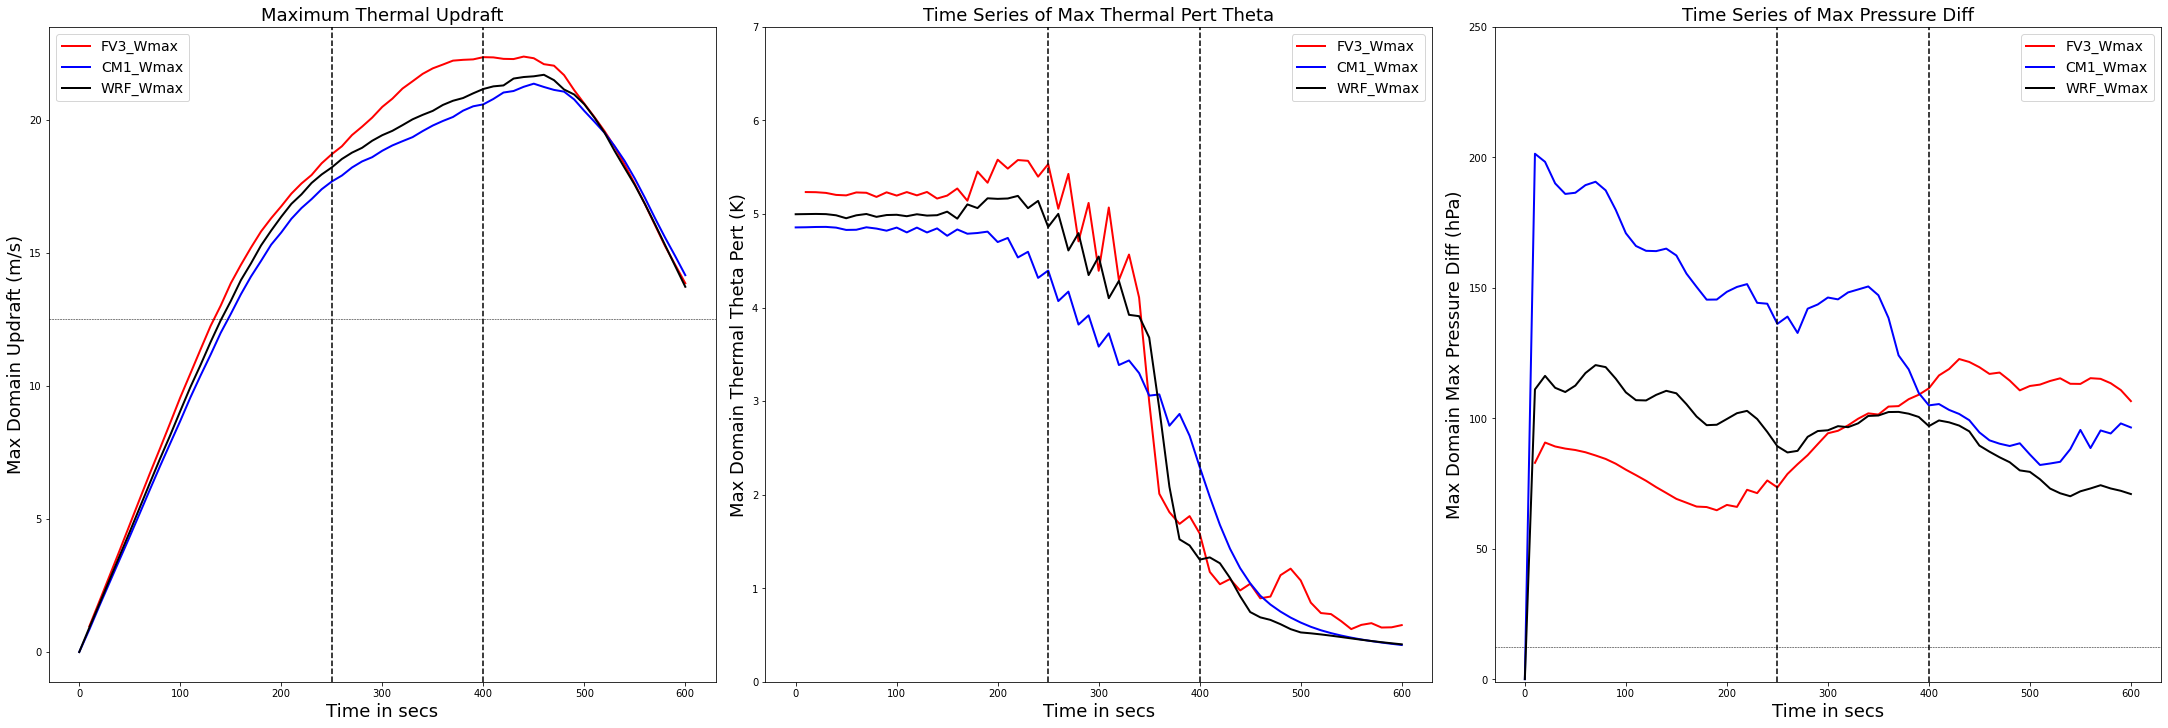

In [134]:
fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]
ax.plot(10+np.arange(60)*10, fv3_fields['w'].max(axis=(1,2,3)), color='r', linewidth=2.0, label='FV3_Wmax')
ax.plot(np.arange(61)*10, cm1_fields['w'].max(axis=(1,2,3)), color='b', linewidth=2.0, label='CM1_Wmax')
ax.plot(np.arange(61)*10, wrf_fields['w'].max(axis=(1,2,3)), color='k', linewidth=2.0, label='WRF_Wmax')
ax.set_title("Maximum Thermal Updraft", fontsize=18)
ax.set_ylabel("Max Domain Updraft (m/s)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.legend(fontsize=14)

ax = axes[1]
ax.plot(10+np.arange(60)*10, fv3_fields['thetap'][:,0:30,127,127].max(axis=(1)), color='r', linewidth=2.0, label='FV3_Wmax')
ax.plot(np.arange(61)*10, cm1_fields['thetap'][:,0:31,127,127].max(axis=(1)), color='b', linewidth=2.0, label='CM1_Wmax')
ax.plot(np.arange(61)*10, wrf_fields['thetap'][:,0:30,127,127].max(axis=(1)), color='k', linewidth=2.0, label='WRF_Wmax')
ax.set_title("Time Series of Max Thermal Pert Theta", fontsize=18)
ax.set_ylabel("Max Domain Thermal Theta Pert (K)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(0.0,7.)
ax.legend(fontsize=14)

ax = axes[2]
ax.plot(10+np.arange(60)*10, fv3_fields['ppres'][:,0:30,127,127].max(axis=(1))-fv3_fields['ppres'][:,0:30,127,127].min(axis=(1)), color='r', linewidth=2.0, label='FV3_Wmax')
ax.plot(np.arange(61)*10, cm1_fields['ppres'][:,0:30,127,127].max(axis=(1))-wrf_fields['ppres'][:,0:30,127,127].min(axis=(1)), color='b', linewidth=2.0, label='CM1_Wmax')
ax.plot(np.arange(61)*10, wrf_fields['ppres'][:,0:30,127,127].max(axis=(1))-wrf_fields['ppres'][:,0:30,127,127].min(axis=(1)), color='k', linewidth=2.0, label='WRF_Wmax')
ax.set_title("Time Series of Max Pressure Diff", fontsize=18)
ax.set_ylabel("Max Domain Max Pressure Diff (hPa)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(-1,250)
ax.legend(fontsize=14)

plt.show()

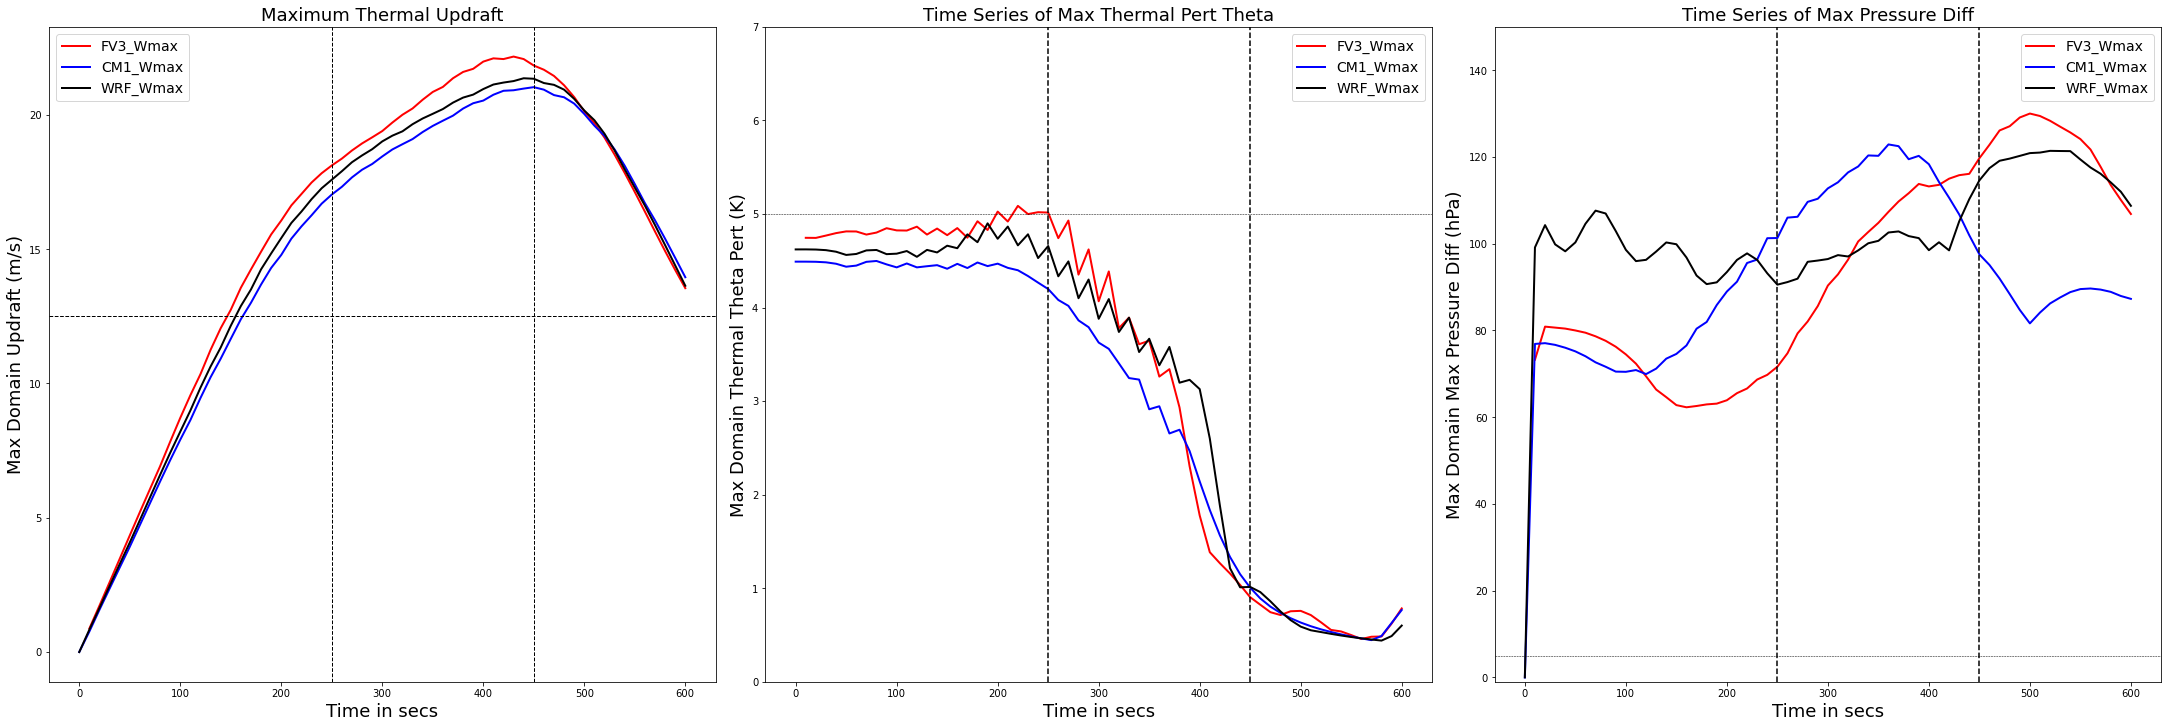

In [148]:
fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]
ax.plot(10+np.arange(60)*10, fv3_profiles['w'].max(axis=0), color='r', linewidth=2.0, label='FV3_Wmax')
ax.plot(np.arange(61)*10,    cm1_profiles['w'].max(axis=0), color='b', linewidth=2.0, label='CM1_Wmax')
ax.plot(np.arange(61)*10,    wrf_profiles['w'].max(axis=0), color='k', linewidth=2.0, label='WRF_Wmax')
ax.set_title("Maximum Thermal Updraft", fontsize=18)
ax.set_ylabel("Max Domain Updraft (m/s)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=1.0)
ax.axvline(x=250,  color='k', linestyle='--',linewidth=1.0)
ax.axvline(x=450,  color='k', linestyle='--',linewidth=1.0)
ax.legend(fontsize=14)

ax = axes[1]
ax.plot(10+np.arange(60)*10, fv3_profiles['t'][0:30,:].max(axis=0), color='r', linewidth=2.0, label='FV3_Wmax')
ax.plot(np.arange(61)*10,    cm1_profiles['t'][0:30,:].max(axis=0), color='b', linewidth=2.0, label='CM1_Wmax')
ax.plot(np.arange(61)*10,    wrf_profiles['t'][0:30,:].max(axis=0), color='k', linewidth=2.0, label='WRF_Wmax')

ax.set_title("Time Series of Max Thermal Pert Theta", fontsize=18)
ax.set_ylabel("Max Domain Thermal Theta Pert (K)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=450, color='k', linestyle='--')
ax.set_ylim(0.0,7.)
ax.legend(fontsize=14)

ax = axes[2]
ax.plot(10+np.arange(60)*10, fv3_profiles['p'][0:30,:].max(axis=0)-fv3_profiles['p'][0:30,:].min(axis=0), color='r', linewidth=2.0, label='FV3_Wmax')
ax.plot(np.arange(61)*10,    cm1_profiles['p'][0:30,:].max(axis=0)-cm1_profiles['p'][0:30,:].min(axis=0), color='b', linewidth=2.0, label='CM1_Wmax')
ax.plot(np.arange(61)*10,    wrf_profiles['p'][0:30,:].max(axis=0)-wrf_profiles['p'][0:30,:].min(axis=0), color='k', linewidth=2.0, label='WRF_Wmax')

ax.set_title("Time Series of Max Pressure Diff", fontsize=18)
ax.set_ylabel("Max Domain Max Pressure Diff (hPa)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=450, color='k', linestyle='--')
ax.set_ylim(-1,150)
ax.legend(fontsize=14)

plt.show()

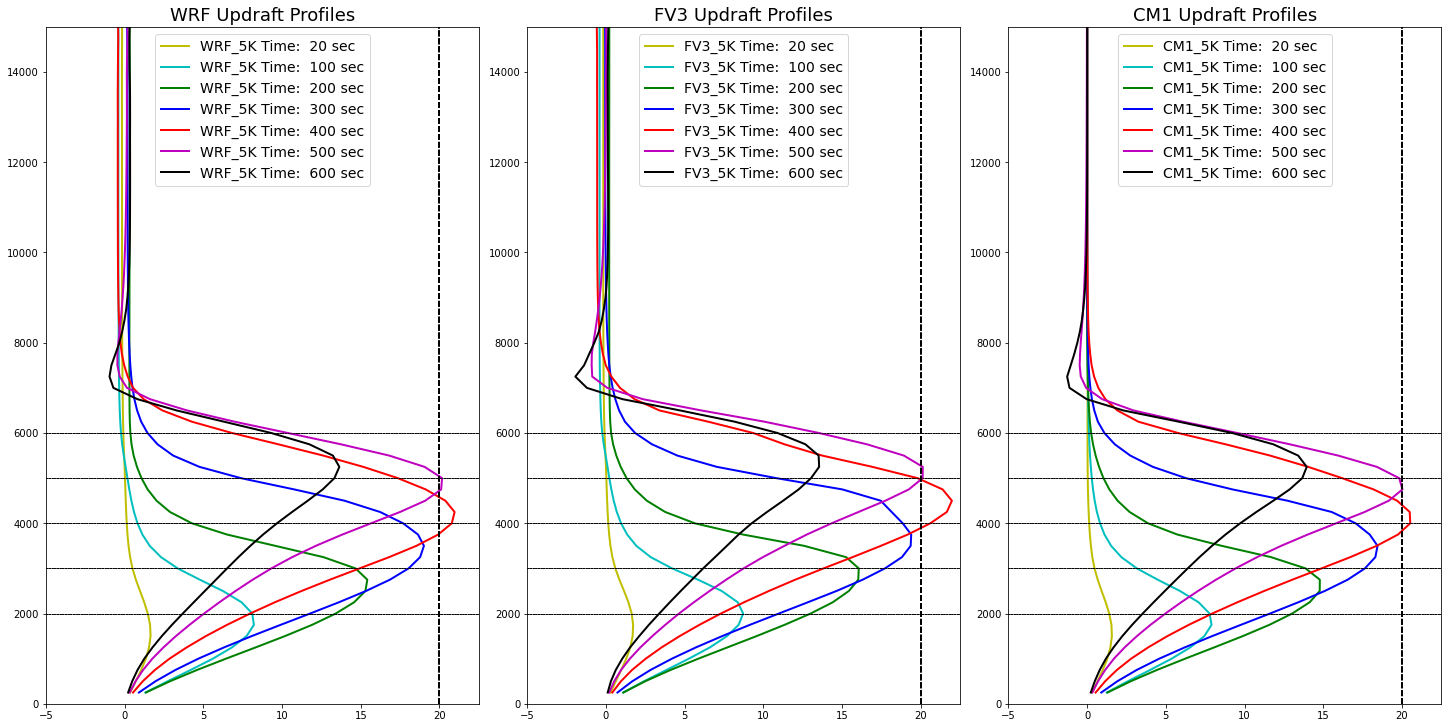

In [139]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    
titles = "Updraft Profiles"

xvert  = 20.0
xlim   = 22.5

lcolors = ['y','c','g','b','r','m','k']

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n, time in enumerate([2,10,20,30,40,50, 60]):
    
    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'], zhgts, time, time, ax0, lcolors[n], 'WRF_5K')
    ax0.set_title("WRF %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    ax0 = ax[1]
    plot_wprofile(fv3_profiles['w'], zhgts, time-1, time, ax0, lcolors[n], 'FV3_5K')
    ax0.set_title("FV3 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    ax0 = ax[2]
    plot_wprofile(cm1_profiles['w'], zhgts, time, time, ax0, lcolors[n], 'CM1_5K')
    ax[2].set_title("CM1 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)

plt.show()



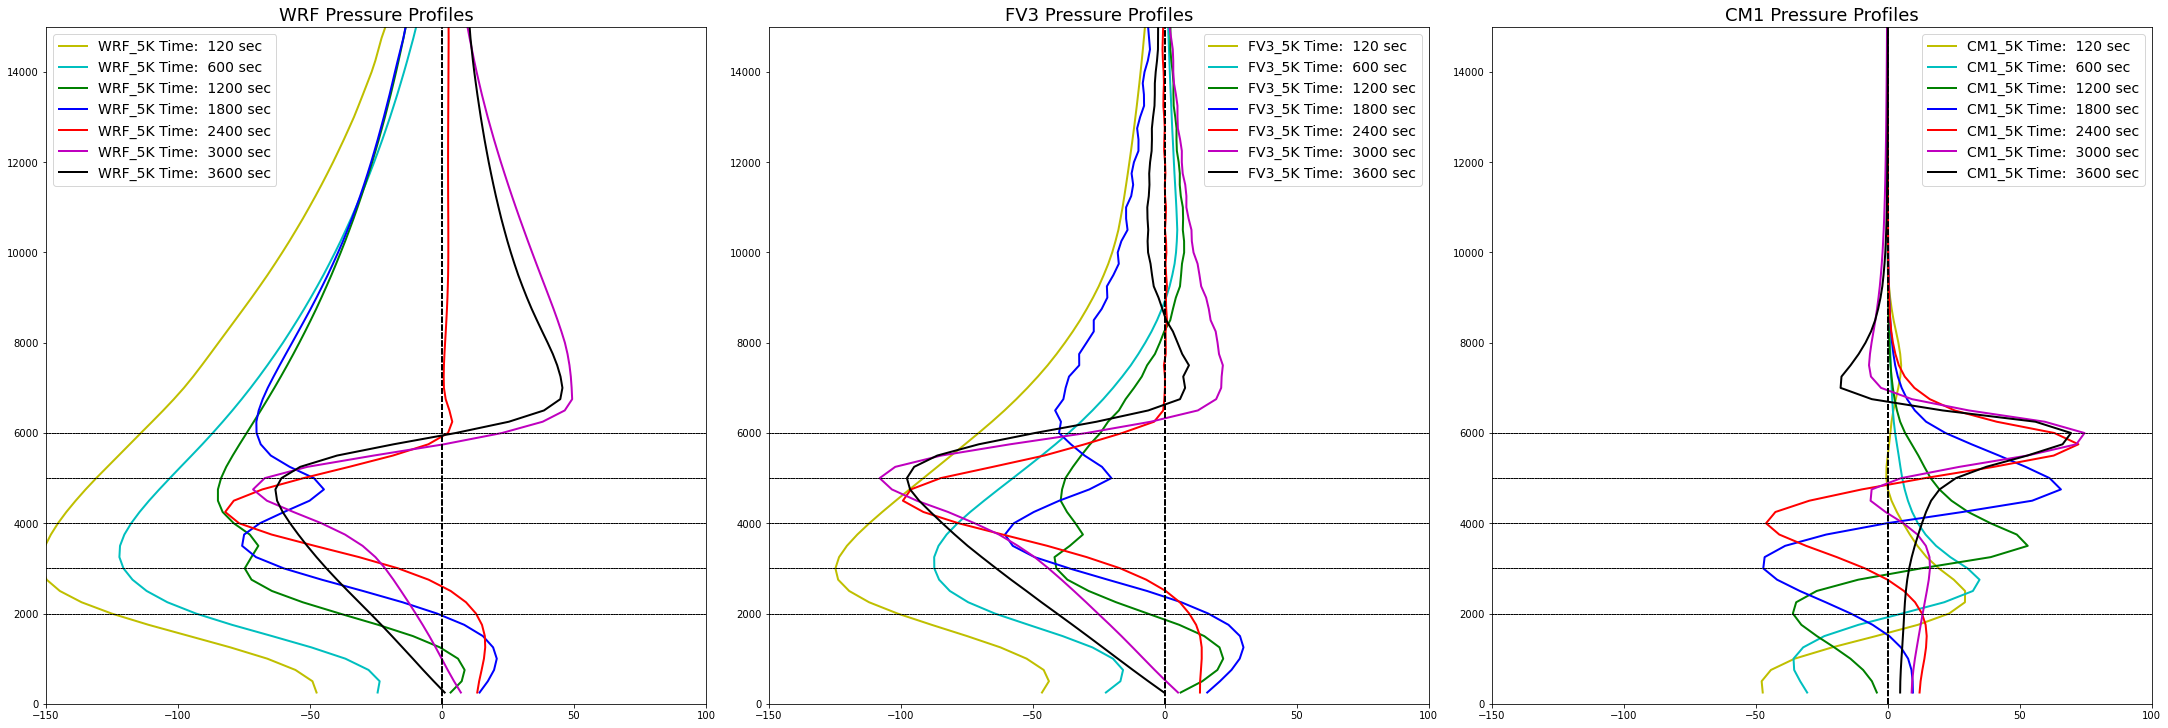

In [152]:
def plot_pprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*60)
    
    ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    
titles = "Pressure Profiles"

xvert  = 0
xlim   = [-150,100]

lcolors = ['y','c','g','b','r','m','k']

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

for n, time in enumerate([2,10,20,30,40,50, 60]):
    
    ax0 = ax[0]
    plot_pprofile(wrf_profiles['p'], zhgts, time, time, ax0, lcolors[n], 'WRF_5K')
    ax0.set_title("WRF %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=2,fontsize=14)
    
    ax0 = ax[1]
    plot_pprofile(fv3_profiles['p'], zhgts, time-1, time, ax0, lcolors[n], 'FV3_5K')
    ax0.set_title("FV3 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)
    
    ax0 = ax[2]
    plot_pprofile(cm1_profiles['p'], zhgts, time, time, ax0, lcolors[n], 'CM1_5K')
    ax0.set_title("CM1 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)

plt.show()

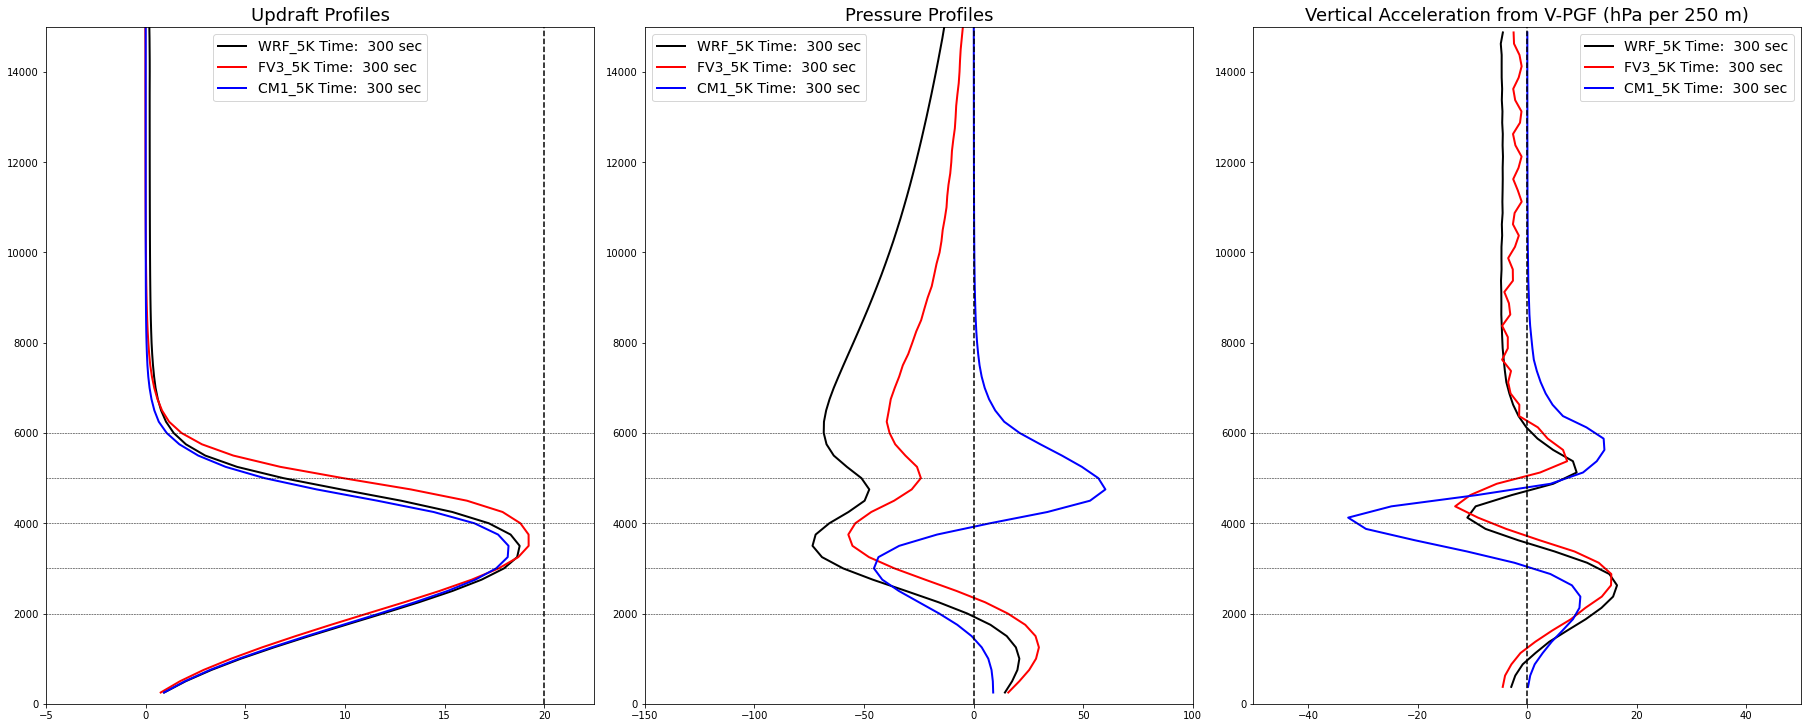

In [235]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if len(time) != 0:
        
        ax.plot(profile[:,time[0]:time[1]].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
        
    else:
        ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    


lcolors = ['c','b','k']
llinewidth = [2.0, 2.0]

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(25,10))


wrf_vpgf   = -(wrf_profiles['p'][1:,:] - wrf_profiles['p'][:-1,:])/(0.5*(wrf_profiles['d'][1:,:] + wrf_profiles['d'][:-1,:]))
fv3_vpgf   = -(fv3_profiles['p'][1:,:] - fv3_profiles['p'][:-1,:])/(0.5*(fv3_profiles['d'][1:,:] + fv3_profiles['d'][:-1,:]))
cm1_vpgf   = -(cm1_profiles['p'][1:,:] - cm1_profiles['p'][:-1,:])/(0.5*(cm1_profiles['d'][1:,:] + cm1_profiles['d'][:-1,:]))
zhgts_vpgf = 0.5*(zhgts[1:] + zhgts[:-1])

for n, time in enumerate([30]):
    
    titles = "Updraft Profiles"
    
    xvert  = 20.0
    xlim   = 22.5
    
    delta = 3
    dtime = [time-delta, time+delta]
    dftime = [time-delta-1, time+delta-1]
    
    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'], zhgts, dtime,  time, ax0, 'k', 'WRF_5K', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['w'], zhgts, dftime, time, ax0, 'r', 'FV3_5K', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['w'], zhgts, dtime,  time, ax0, 'b', 'CM1_5K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    xvert  = 0
    xlim   = [-150,100]
    
    titles = "Pressure Profiles"
    ax0 = ax[1]
    plot_wprofile(wrf_profiles['p'], zhgts, dtime,   time, ax0, 'k', 'WRF_5K', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['p'], zhgts, dftime, time, ax0, 'r', 'FV3_5K', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['p'], zhgts, dtime,   time, ax0, 'b', 'CM1_5K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)

    xvert  = 0
    xlim   = [-50,50]
    
    titles = "Vertical Acceleration from V-PGF (hPa per 250 m)"
    ax0 = ax[2]
    
    plot_wprofile(wrf_vpgf, zhgts_vpgf, dtime,   time, ax0, 'k', 'WRF_5K', linewidth=llinewidth[n])
    plot_wprofile(fv3_vpgf, zhgts_vpgf, dftime, time, ax0, 'r', 'FV3_5K', linewidth=llinewidth[n])
    plot_wprofile(cm1_vpgf, zhgts_vpgf, dtime,   time, ax0, 'b', 'CM1_5K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

plt.show()

In [ ]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if len(time) != 0:
        ax.plot(profile[:,time[0]:time[1]].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
        
    else:
        ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)


lcolors = ['c','b','k']
llinewidth = [0.5, 2.0]

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))


wrf_vpgf   = -(wrf_profiles['p'][1:,:] - wrf_profiles['p'][:-1,:])/(0.5*(wrf_profiles['d'][1:,:] + wrf_profiles['d'][:-1,:]))
fv3_vpgf   = -(fv3_profiles['p'][1:,:] - fv3_profiles['p'][:-1,:])/(0.5*(fv3_profiles['d'][1:,:] + fv3_profiles['d'][:-1,:]))
cm1_vpgf   = -(cm1_profiles['p'][1:,:] - cm1_profiles['p'][:-1,:])/(0.5*(cm1_profiles['d'][1:,:] + cm1_profiles['d'][:-1,:]))
zhgts_vpgf = 0.5*(zhgts[1:] + zhgts[:-1])


wrf_sum = np.cumsum(wrf_vpgf,axis=0)
fv3_sum = np.cumsum(fv3_vpgf,axis=0)
cm1_sum = np.cumsum(cm1_vpgf,axis=0)

for n, time in enumerate([30]):
    
    titles = "Updraft Profiles"
    
    xvert  = 20.0
    xlim   = 22.5
    
    delta = 3
    dtime = [time-delta, time+delta]
    dftime = [time-delta-1, time+delta-1]

    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'], zhgts, dtime,  time, ax0, 'k', 'WRF_5K', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['w'], zhgts, dftime, time, ax0, 'r', 'FV3_5K', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['w'], zhgts, dtime,  time, ax0, 'b', 'CM1_5K', linewidth=llinewidth[n])

    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    xvert  = 0
    xlim   = [-50,50]

    titles = "Vertical Acceleration from V-PGF (hPa per 250 m)"
    ax0 = ax[1]
    
    plot_wprofile(wrf_vpgf, zhgts_vpgf, dtime, time, ax0, 'k', 'WRF_5K', linewidth=llinewidth[n])
    plot_wprofile(fv3_vpgf, zhgts_vpgf, dtime, time, ax0, 'r', 'FV3_5K', linewidth=llinewidth[n])
    plot_wprofile(cm1_vpgf, zhgts_vpgf, dtime, time, ax0, 'b', 'CM1_5K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

    xvert  = 0
    xlim   = [-100,100]
    
    titles = "Cumulative sum of Vertical Acceleration"
    ax0 = ax[2]
    plot_wprofile(wrf_sum, zhgts_vpgf, dtime, time, ax0, 'k', 'WRF_5K', linewidth=llinewidth[n])
    plot_wprofile(fv3_sum, zhgts_vpgf, dtime, time, ax0, 'r', 'FV3_5K', linewidth=llinewidth[n])
    plot_wprofile(cm1_sum, zhgts_vpgf, dtime, time, ax0, 'b', 'CM1_5K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)


plt.show()

In [61]:
print(fv3_profiles['t'].max(axis=0))

[131.35406 131.31604 131.31506 131.35522 131.41469 131.4808  131.54826
 131.61467 131.67845 131.7381  131.79181 131.83783 131.87448 131.90028
 131.91412 131.91528 131.90396 131.88092 131.84695 131.80202 131.74687
 131.68945 131.63184 131.56793 131.49445 131.44476 131.39919 131.35039
 131.31708 131.30151 131.29204 131.29247 131.31227 131.34596 131.38211
 131.43034 131.48969 131.55511 131.62012 131.68471 131.74847 131.80772
 131.86    131.90178 131.93839 131.96461 131.98383 131.98335 131.96613
 131.94176 131.90735 131.8637  131.81374 131.75705 131.69833 131.63882
 131.5788  131.51974 131.46648 131.4203 ]


In [215]:
print(' {:02} {:10.4f} {:10.4f}'.format(3, 10.334444 \
                                        , 10000.2))
print(' {:02} {:10.4f} {:10.4f}'.format(3, 1.334444, 0.023))

 03    10.3344 10000.2000
 03     1.3344     0.0230
